In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

# Load the data.

In [3]:
df = pd.read_csv('housing.csv')

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Look at the median_house_value variable. Does it have a long tail?

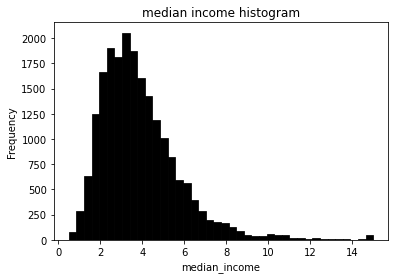

In [5]:
#plot the histogram of the median price
plt.figure(figsize=(6, 4))

sns.histplot(df.median_income, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('median_income')
plt.title('median income histogram')

plt.show()

# selecting columns needed for the excercise

In [6]:
headers = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households',
    'median_income','median_house_value']

In [7]:
df = df[headers]

# Question 1
Find a feature with missing values. How many missing values does it have?

In [8]:
#checking columns with missing values 
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

#### only total_bedroom has 207 missing values 

# Question 2
What's the median (50% percentile) for variable 'population'?

In [9]:
df.population.describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

#### 50% percentile 1166.000000

## b) Split the data

In [10]:
#shuffle the dataset and use seed 42 to ensure shuffle is constant
np.random.seed(42)

## c) Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [11]:
#we define a function to help us split the dataset

def split_data(X):
    #shuffle the dataset and use seed 42 to ensure shuffle is constant
    np.random.seed(42)
    #the length of the dataset
    n = len(X)

    #we use 60% for train 20% for test and 20% for validate
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    #genrate a set of numbers from 0 to n, where n is the length of the array
    idx = np.arange(n)
    #we shuffle the numbers
    np.random.shuffle(idx)

    #we use the shuffled numbers to rearrange the dataframe
    X_shuffled = X.iloc[idx]

    #we copy their data into their corresponding dataframe
    X_train = X_shuffled.iloc[:n_train].copy()
    X_val = X_shuffled.iloc[n_train:n_train+n_val].copy()
    X_test = X_shuffled.iloc[n_train+n_val:].copy()
    
    return X_train,X_val,X_test 

In [12]:
#we calll the function to get the respective dataframe
df_train,df_val,df_test = split_data(df[headers])

#### Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [13]:
#we get target values from the dataset
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

#we convert the values to be predicted to log, to normalize it and reduce it
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# Question 3

    We need to deal with missing values for the column from Q1.
    We have two options: fill it with 0 or with the mean of this variable.
    Try both options. For each, train a linear regression model without regularization using the code from the lessons.
    For computing the mean, use the training only!
    Use the validation dataset to evaluate the models and compare the RMSE of each option.
    Round the RMSE scores to 2 decimal digits using round(score, 2)
    Which option gives better RMSE?


In [14]:
#check the sum of null values
df_train.total_bedrooms.isnull().sum()

207

In [15]:
#we define linear regression algorithm
def train_linear_regression(X, y):
    #creates an array of ones 
    ones = np.ones(X.shape[0])
    #adds 1s to the matrix X, these ones are baseline, eg. how much it should cost when we dont know any feature
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    #w[0] is the base weight, w[1:] curresponding array of weights for the rest
    return w[0], w[1:]

In [16]:
base = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households',
    'median_income']

In [17]:
#base = ['total_bedrooms']

In [18]:
#we define a function that 
def prepare_X(df):
    #select all the columns in base 
    df_num = df[base]
    
    #fill the empty rows with 0  
     #-> df_num = df_num.fillna(0).isnull.sum() to verify
    #used k to check the diffrence between using 0 and bedroom mean
    #k = (df['total_bedrooms']).mean()
    k = 0
    df_num['total_bedrooms'] = df_num.total_bedrooms.fillna(k)
    #store all the values
    X = df_num.values
    return X

In [19]:
#we prepare the training data
X_train = prepare_X(df_train)
#we get the base weight and weight
w_0, w = train_linear_regression(X_train, y_train)


In [20]:
#we predict y_pred using the base weight
y_pred = w_0 + X_train.dot(w)
y_pred

array([11.28055213, 11.90427911, 12.46507934, ..., 11.53259294,
       11.92377088, 12.54517195])

In [21]:
# we calculate the rmse of both
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    score = np.sqrt(mse) 
    return round(score, 2)
    #return score

In [22]:
rmse(y_train, y_pred)

0.34

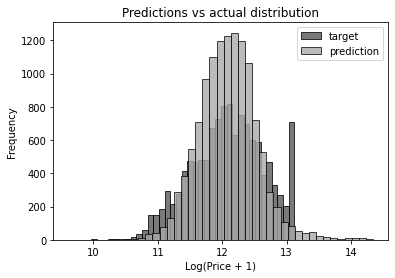

In [23]:
plt.figure(figsize=(6, 4))


sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

# Question 4

    Now let's train a regularized linear regression.
    For this question, fill the NAs with 0.
    Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
    Use RMSE to evaluate the model on the validation dataset.
    Round the RMSE scores to 2 decimal digits.
    Which r gives the best RMSE?


In [24]:
#regularization means controlling the weights so they dont grow too much
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    
    #multiplies the diagonal by 0.0, this is done to control duplicate columns
    #because inverse of duplicate columns cannot be found
    #an array is created called reg this process is called regularization
    reg = r * np.eye(XTX.shape[0])
    
    #we add the arrays
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [25]:

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_train.dot(w)
    x = rmse(y_train, y_pred)
    print (f"the r is {r}, the rmse is {x}")

the r is 0, the rmse is 0.34
the r is 1e-06, the rmse is 0.34
the r is 0.0001, the rmse is 0.34
the r is 0.001, the rmse is 0.34
the r is 0.01, the rmse is 0.34
the r is 0.1, the rmse is 0.34
the r is 1, the rmse is 0.35
the r is 5, the rmse is 0.35
the r is 10, the rmse is 0.35


### smallest r is 0

# Question 5

    We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
    Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
    For each seed, do the train/validation/test split with 60%/20%/20% distribution.
    Fill the missing values with 0 and train a model without regularization.
    For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
    Round the result to 3 decimal digits (round(std, 3))


In [26]:
#we define a function to help us split the dataset

def split_dt(X):
    #shuffle the dataset and use seed 42 to ensure shuffle is constant

    #the length of the dataset
    n = len(X)

    #we use 60% for train 20% for test and 20% for validate
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    #genrate a set of numbers from 0 to n, where n is the length of the array
    idx = np.arange(n)
    #we shuffle the numbers
    np.random.shuffle(idx)

    #we use the shuffled numbers to rearrange the dataframe
    X_shuffled = X.iloc[idx]

    #we copy their data into their corresponding dataframe
    X_train = X_shuffled.iloc[:n_train].copy()
    X_val = X_shuffled.iloc[n_train:n_train+n_val].copy()
    X_test = X_shuffled.iloc[n_train+n_val:].copy()
    
    return X_train,X_val,X_test 

In [27]:
df_train,df_val,df_test = split_data(df[headers])

In [28]:
def get_target(df_train,df_val,df_test):
    #we get target values from the dataset
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    #we convert the values to be predicted to log, to normalize it and reduce it
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    return y_train,y_val,y_test

In [46]:
seed_value = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
stand_err = []
def seed_trys(df):
    for i in seed_value:
        np.random.seed(i)    
        df_train,df_val,df_test = split_dt(df)
        y_train,y_val,y_test = get_target(df_train,df_val,df_test)
        X_train = prepare_X(df_train)
        w_0, w = train_linear_regression(X_train, y_train)
        X_val = prepare_X(df_val)
        y_pred = w_0 + X_val.dot(w)
        error = rmse(y_val, y_pred)
        #print(f"the seed is {i} and the RMSE is {error}")
        stand_err.append(error)
        x = df_train.total_bedrooms.isnull().sum()
        print(f"the seed is {i} and the RMSE is {error} and {x}")
    return stand_err

In [47]:
ans = seed_trys(df[headers])

the seed is 0 and the RMSE is 0.34 and 128
the seed is 1 and the RMSE is 0.34 and 124
the seed is 2 and the RMSE is 0.33 and 122
the seed is 3 and the RMSE is 0.34 and 123
the seed is 4 and the RMSE is 0.34 and 140
the seed is 5 and the RMSE is 0.34 and 129
the seed is 6 and the RMSE is 0.35 and 121
the seed is 7 and the RMSE is 0.34 and 125
the seed is 8 and the RMSE is 0.35 and 130
the seed is 9 and the RMSE is 0.34 and 120


In [48]:
ans

[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]

In [49]:
answer = round(np.std(ans),3)

In [50]:
answer

0.005

# Question 6

    Split the dataset like previously, use seed 9.
    Combine train and validation datasets.
    Fill the missing values with 0 and train a model with r=0.001.
    What's the RMSE on the test dataset?


In [120]:
seed_value = [9]
def seed_test(df):
    for i in seed_value:
        np.random.seed(i)    
        df_train,df_val,df_test = split_dt(df)
        #concat df_train and df_val
        df_train = pd.concat([df_train,df_val])
        #fill missing values with zero
        df_train = df_train.fillna(0)
        X_train = prepare_X(df_train)
        
        y_train,y_val,y_test = get_target(df_train,df_val,df_test)
           
        w_0, w = train_linear_regression_reg(X_train, y_train,r =0.001)
        X_test = prepare_X(df_test)
        y_pred = w_0 + X_test.dot(w)
        #check error between predicted test and real test
        error = rmse(y_test, y_pred)

        x = df_train.total_bedrooms.isnull().sum()
        print(f"the seed is {i} and the RMSE is {error}")
    return 

In [122]:
seed_test(df[headers])

the seed is 9 and the RMSE is 0.35


<ipython-input-18-3e72ccbf8e4b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['total_bedrooms'] = df_num.total_bedrooms.fillna(k)
